In [1]:
#imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os

In [3]:
# Title: Sample Large CSV file in Chunks 

# Description:
# Read large combined flight data file in 1-million-row chunks, 
# randomly samples 10% of each chunk to reduce data size, 
# combines the samples into one DataFrame, 
# and prints the final shape for further analysis.

In [4]:

processed_folder = 'output/processed_chunks'
sampled_chunks = []

# Loop through all processed chunk files
for file_name in sorted(os.listdir(processed_folder)):
    if file_name.endswith('.csv'):
        file_path = os.path.join(processed_folder, file_name)
        chunk = pd.read_csv(file_path)
        print(f"Processing {file_name} with shape {chunk.shape}")
        
        # Sample 10% of each chunk
        sampled = chunk.sample(frac=0.1, random_state=42)
        sampled_chunks.append(sampled)

# Combine all sampled subsets
df = pd.concat(sampled_chunks, ignore_index=True)
print(f"Combined sampled shape: {df.shape}")


Processing processed_chunk_0.csv with shape (1000000, 196)
Processing processed_chunk_1.csv with shape (1000000, 196)
Processing processed_chunk_10.csv with shape (1000000, 196)
Processing processed_chunk_3.csv with shape (1000000, 196)
Processing processed_chunk_4.csv with shape (1000000, 196)
Processing processed_chunk_5.csv with shape (1000000, 196)
Processing processed_chunk_6.csv with shape (1000000, 196)
Processing processed_chunk_9.csv with shape (1000000, 196)
Combined sampled shape: (800000, 196)


In [19]:
# Title: Clean Sampled Data

# Description:
# Drops columns with more than 50% missing values, 
# fills remaining NaNs with zeros, 
# removes non-numeric columns like 'filename' if present, 
# and prints the final cleaned DataFrame dimensions.

In [20]:
# Drop columns with >50% NaNs
df = df.dropna(axis=1, thresh=len(df)*0.5)

# Fill remaining NaNs
df = df.fillna(0)

# Drop non-numeric columns like filename (if present)
if 'filename' in df.columns:
    df = df.drop(columns=['filename'])

print(f"Cleaned sampled data dimensions: {df.shape}")


Cleaned sampled data dimensions: (800000, 195)


In [21]:
print("Assigning flight phases...")

# Smooth altitude and calculate rate of change
df['ALT_smooth'] = df['ALT'].rolling(window=5, center=True, min_periods=1).mean()
df['ALT_diff'] = df['ALT'].diff()
df['ALT_diff_smooth'] = df['ALT_diff'].rolling(window=5, center=True, min_periods=1).mean()

# new column
df['phase_refined'] = 'unknown'

# Taxi: near ground, low vertical movement
taxi_cond = (df['ALT_smooth'] < 300) & (df['ALT_diff_smooth'].abs() < 5)
df.loc[taxi_cond, 'phase_refined'] = 'taxi'

# Ascent: incresed altitude
climb_cond = (df['ALT_smooth'] >= 300) & (df['ALT_smooth'] < 10000) & (df['ALT_diff_smooth'] > 10)
df.loc[climb_cond, 'phase_refined'] = 'climb'

# Cruise: high, level altitude
cruise_cond = (df['ALT_smooth'] >= 10000) & (df['ALT_diff_smooth'].abs() < 20)
df.loc[cruise_cond, 'phase_refined'] = 'cruise'

# Descent: decreased altitude
descent_cond = (df['ALT_smooth'] >= 1000) & (df['ALT_diff_smooth'] < -10)
df.loc[descent_cond, 'phase_refined'] = 'descent'

print("Phase labeling complete.")


Assigning flight phases...
Phase labeling complete.


In [22]:
print("Phase distribution:")
print(df['phase_refined'].value_counts())


Phase distribution:
unknown    358091
taxi       203430
climb      129620
descent     90718
cruise      18141
Name: phase_refined, dtype: int64


In [23]:
# Title: Summary of Phase and Cluster Counts

# Description:
# Prints the count of records in each flight phase (taxi, climb, cruise, unknown) and the count of records in each
# cluster assigned by the KMeans algorithm.

In [24]:
print(" Phase counts:")
print(df['phase'].value_counts())

print("Cluster counts:")
print(df['cluster'].value_counts())


 Phase counts:
taxi      650400
cruise    108698
climb      40902
Name: phase, dtype: int64
Cluster counts:
0    643277
1    109293
3     33494
2     13936
Name: cluster, dtype: int64


In [25]:
# Title: Visualize Altitude by Cluster and Phase

# Description:
# Creates scatter plots showing altitude over record index, 
# colored by cluster assignments,
# and separated by flight phase to help visualize altitude patterns across different flight phases.


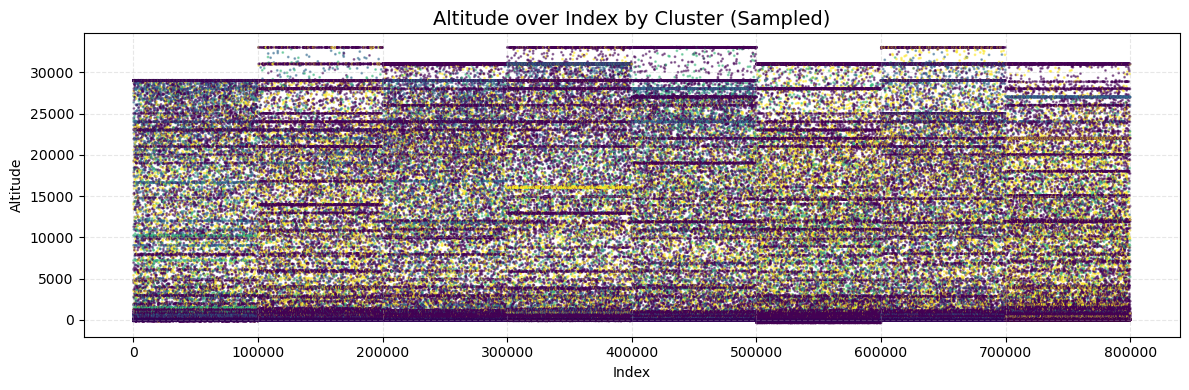

/var/folders/1x/7dv9f0r12dgdq2jhl_yjy8g80000gn/T/ipykernel_8148/1615653664.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['ALT_smooth'] = subset['ALT'].rolling(window=smoothing_window, center=True, min_periods=1).mean()


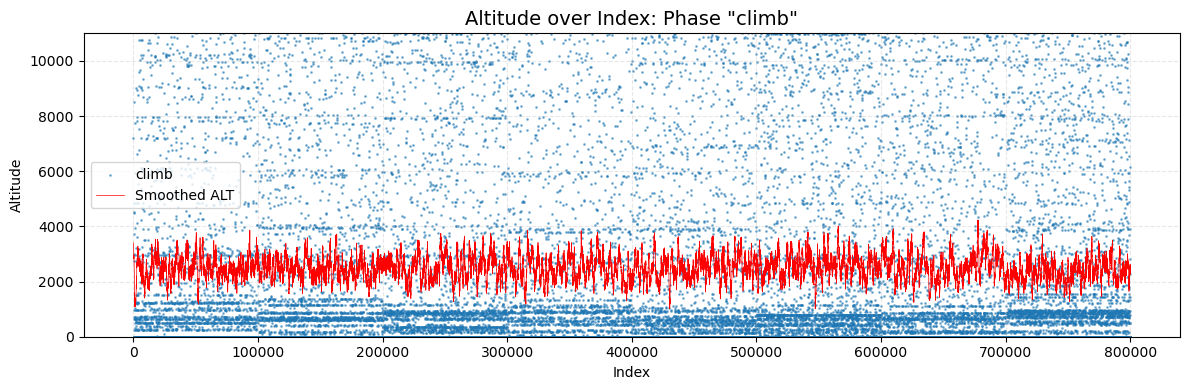

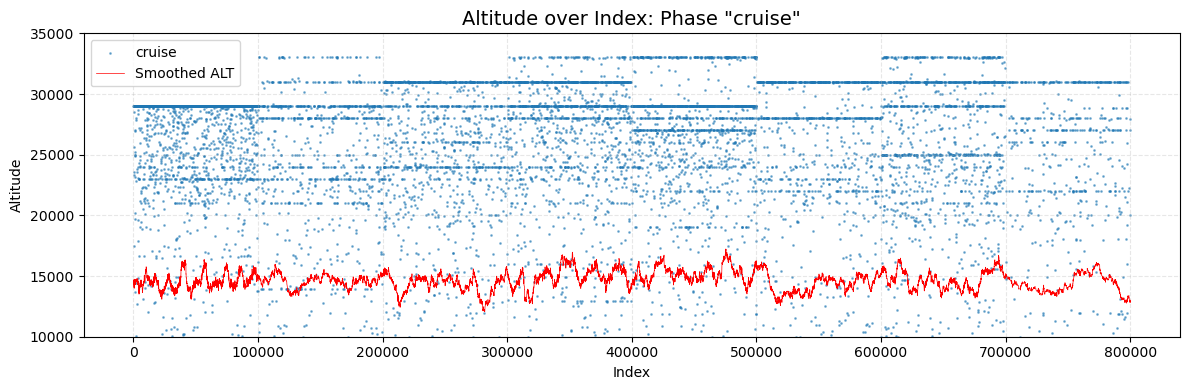

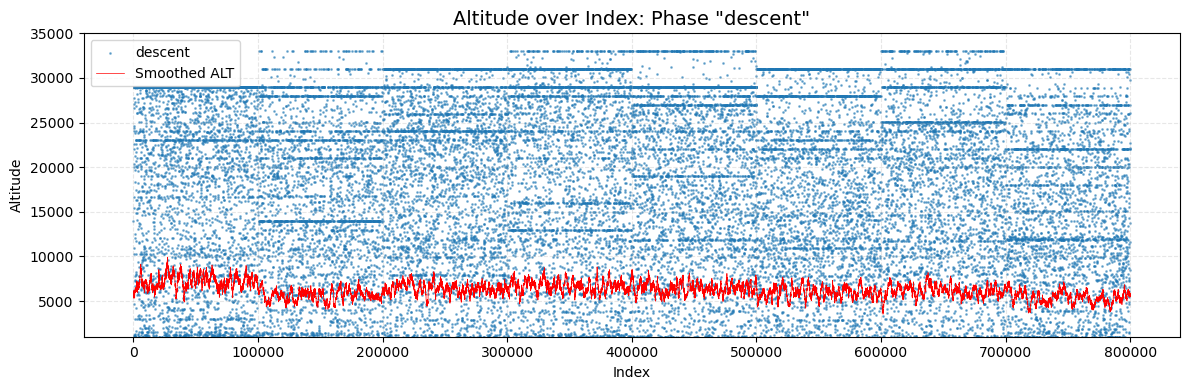

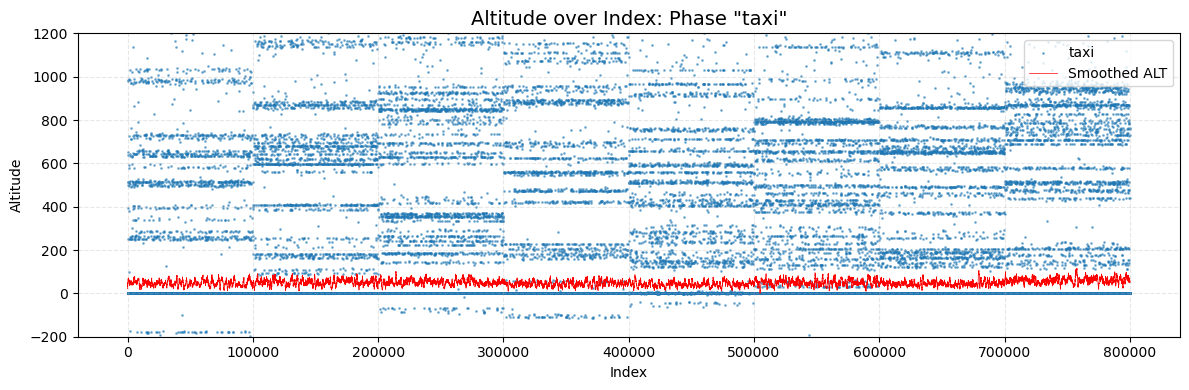

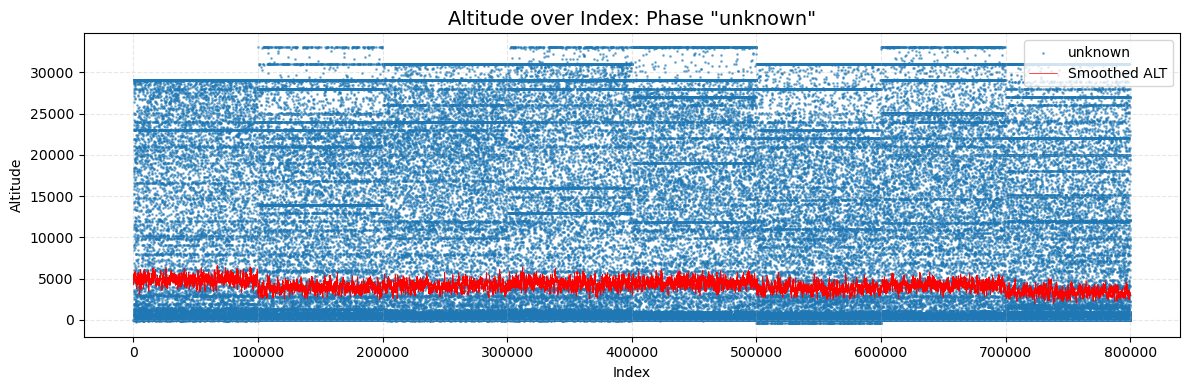

In [26]:
import matplotlib.pyplot as plt

# smoothing window size ''' why this size?
smoothing_window = 200

# Define custom y-limits for zooming by phase
ylim_dict = {
    'taxi': (-200, 1200),
    'climb': (0, 11000),
    'cruise': (10000, 35000),
    'descent': (1000, 35000), # according to ...
}

# Plot: Altitude by Cluster 
plt.figure(figsize=(12, 4))
plt.scatter(df.index, df['ALT'], c=df['cluster'], cmap='viridis', s=1, alpha=0.5)
plt.title('Altitude over Index by Cluster (Sampled)', fontsize=14)
plt.xlabel('Index')
plt.ylabel('Altitude')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot: Altitude by Phase 
for phase in sorted(df['phase_refined'].dropna().unique()):
    subset = df[df['phase_refined'] == phase]
    
    # Smoothed altitude
    subset['ALT_smooth'] = subset['ALT'].rolling(window=smoothing_window, center=True, min_periods=1).mean()
    
    plt.figure(figsize=(12, 4))
    plt.scatter(subset.index, subset['ALT'], label=f'{phase}', s=1, alpha=0.5)
    plt.plot(subset.index, subset['ALT_smooth'], color='red', linewidth=0.5, label='Smoothed ALT')
    
    # Zoom y-axis if phase is in dictionary
    if phase in ylim_dict:
        plt.ylim(ylim_dict[phase])
    
    plt.title(f'Altitude over Index: Phase "{phase}"', fontsize=14)
    plt.xlabel('Index')
    plt.ylabel('Altitude')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


In [27]:
# Title: Phase vs. Cluster Crosstab and Heatmap

# Description:
# This section creates a crosstab table and heatmap showing the relationship 
# between flight phases and KMeans clusters, allowing you to evaluate 
# how well the clustering aligns with the phase labels.



 Phase vs. Cluster Crosstab:
 cluster       0      1     2      3
phase                              
climb     25194   3784  4058   7866
cruise    71847  15552  6637  14662
taxi     546236  89957  3241  10966


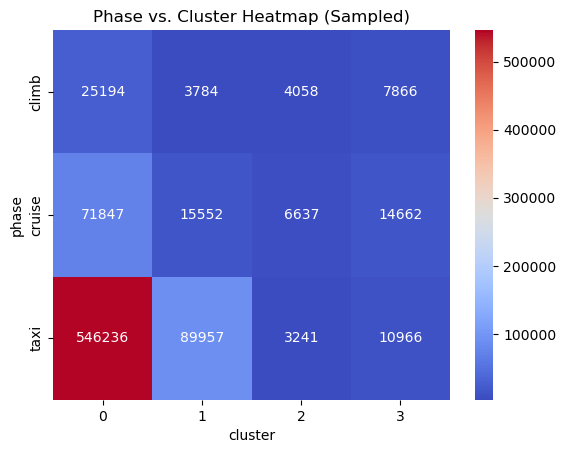

In [28]:
cross_tab = pd.crosstab(df['phase'], df['cluster'])
print("\n Phase vs. Cluster Crosstab:\n", cross_tab)

sns.heatmap(cross_tab, annot=True, fmt='d', cmap='coolwarm')
plt.title('Phase vs. Cluster Heatmap (Sampled)')
plt.show()


In [29]:
# Title: Feature Correlation Heatmap

# Description:
# Computes correlation matrix between all numeric features 
# (excluding phase and cluster) and visualizes it as a heatmap 
# to reveal relationships and potential dependencies between variables.


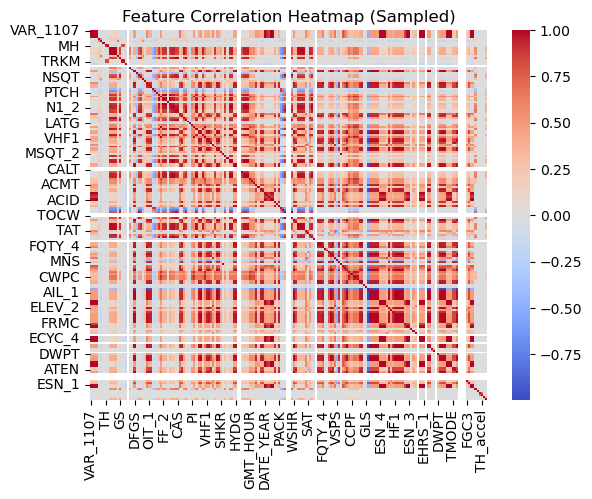

In [30]:
features = [col for col in df.columns if df[col].dtype != 'object' and col not in ['phase', 'cluster']]
corr = df[features].corr()

sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap (Sampled)')
plt.show()
